pip install pandas numpy matplotlib seaborn scikit-learn statsmodels tensorflow yfinance


## Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Data Collection

Step-by-step instructions:

1. Define the ticker symbol for Walmart. Walmart's ticker symbol is WMT.
2. Specify the date range from 1972-01-01 to 2022-12-31.
3. Fetch the data using yfinance.

In [3]:
# Define ticker symbol and date range
ticker_symbol = 'WMT'
start_date = '1972-01-01'
end_date = '2022-12-31'

# Fetch data
walmart_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows
print(walmart_data.head())


[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
1972-08-25  0.021159  0.021566  0.021159  0.021484   0.011664  7526400
1972-08-28  0.021484  0.021647  0.021403  0.021403   0.011620  2918400
1972-08-29  0.021322  0.021322  0.021159  0.021159   0.011488  5836800
1972-08-30  0.021159  0.021159  0.020996  0.021159   0.011488  1228800
1972-08-31  0.020996  0.020996  0.020833  0.020833   0.011311  2611200


## Data Preprocessing

1. Handling missing values: Check for and handle any missing data.
2. Reset index: Ensure the date is a column for easier manipulation.
3. Selecting relevant columns: We'll focus on the 'Close' price for prediction.


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


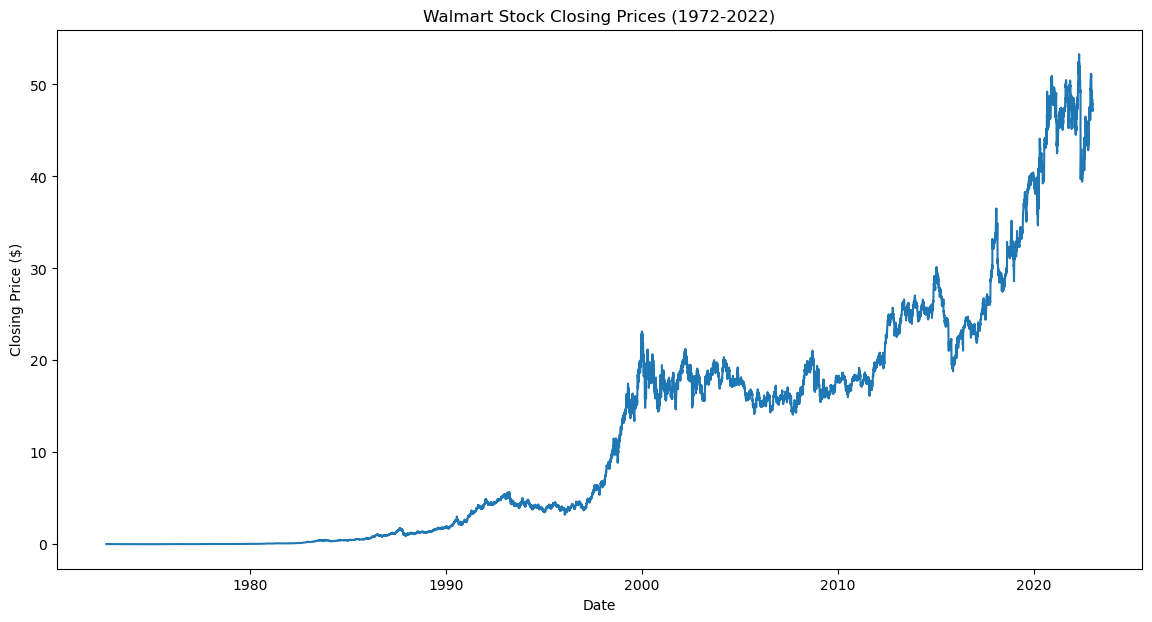

In [4]:
# Check for missing values
print(walmart_data.isnull().sum())

# Since there are no missing values, proceed to reset index
walmart_data.reset_index(inplace=True)

# Selecting the 'Date' and 'Close' columns
walmart_data = walmart_data[['Date', 'Close']]

# Visualizing the closing price over time
plt.figure(figsize=(14, 7))
plt.plot(walmart_data['Date'], walmart_data['Close'])
plt.title('Walmart Stock Closing Prices (1972-2022)')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.show()

## Exploratory Data Analysis (EDA)

1. Descriptive statistics: Get summary statistics of the closing prices.
2. Moving averages: Calculate and plot short-term and long-term moving averages.
3. Seasonality and trends: Decompose the time series to observe components.

count    12697.000000
mean        12.382629
std         13.046725
min          0.005208
25%          0.476563
50%          6.197917
75%         19.139999
max         53.290001
Name: Close, dtype: float64


/var/folders/s0/2twvhfs95kz1b69bck8s47140000gn/T/ipykernel_951/465420809.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walmart_data['MA50'] = walmart_data['Close'].rolling(window=50).mean()
/var/folders/s0/2twvhfs95kz1b69bck8s47140000gn/T/ipykernel_951/465420809.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walmart_data['MA200'] = walmart_data['Close'].rolling(window=200).mean()


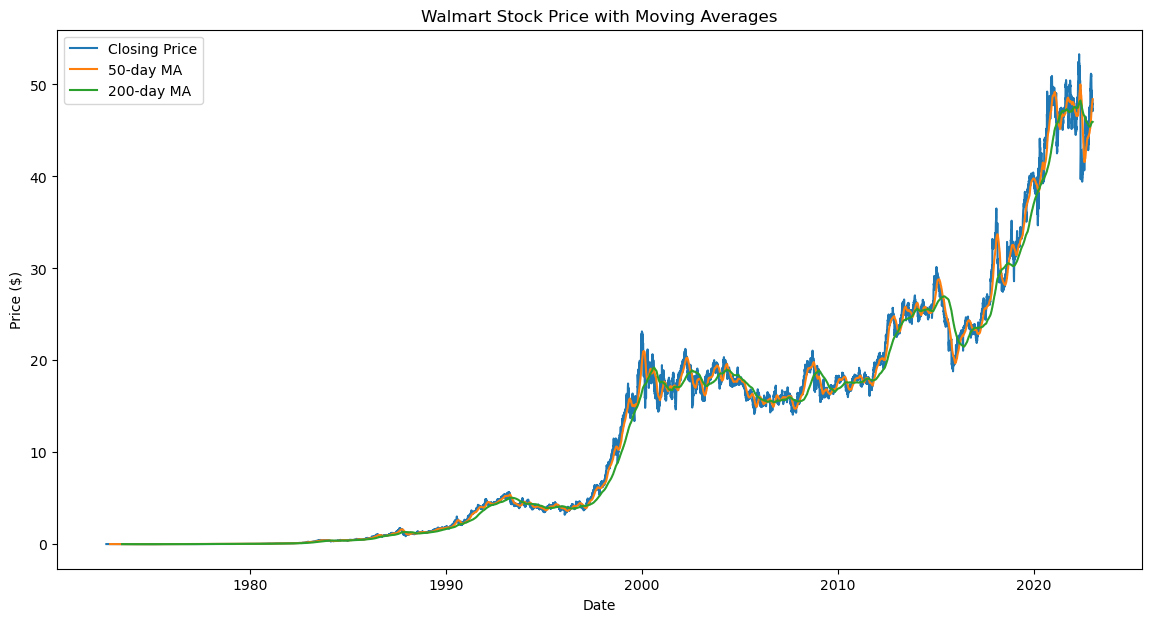

In [5]:
# Descriptive statistics
print(walmart_data['Close'].describe())

# Calculating moving averages
walmart_data['MA50'] = walmart_data['Close'].rolling(window=50).mean()
walmart_data['MA200'] = walmart_data['Close'].rolling(window=200).mean()

# Plotting moving averages
plt.figure(figsize=(14, 7))
plt.plot(walmart_data['Date'], walmart_data['Close'], label='Closing Price')
plt.plot(walmart_data['Date'], walmart_data['MA50'], label='50-day MA')
plt.plot(walmart_data['Date'], walmart_data['MA200'], label='200-day MA')
plt.title('Walmart Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


1. 50-day and 200-day moving averages to smooth out short-term fluctuations and highlight longer-term trends.
2. The plot shows how the stock price moves relative to its moving averages.

## Checking for Seasonality

Decompose the time series to see the trend, seasonality, and residual components.

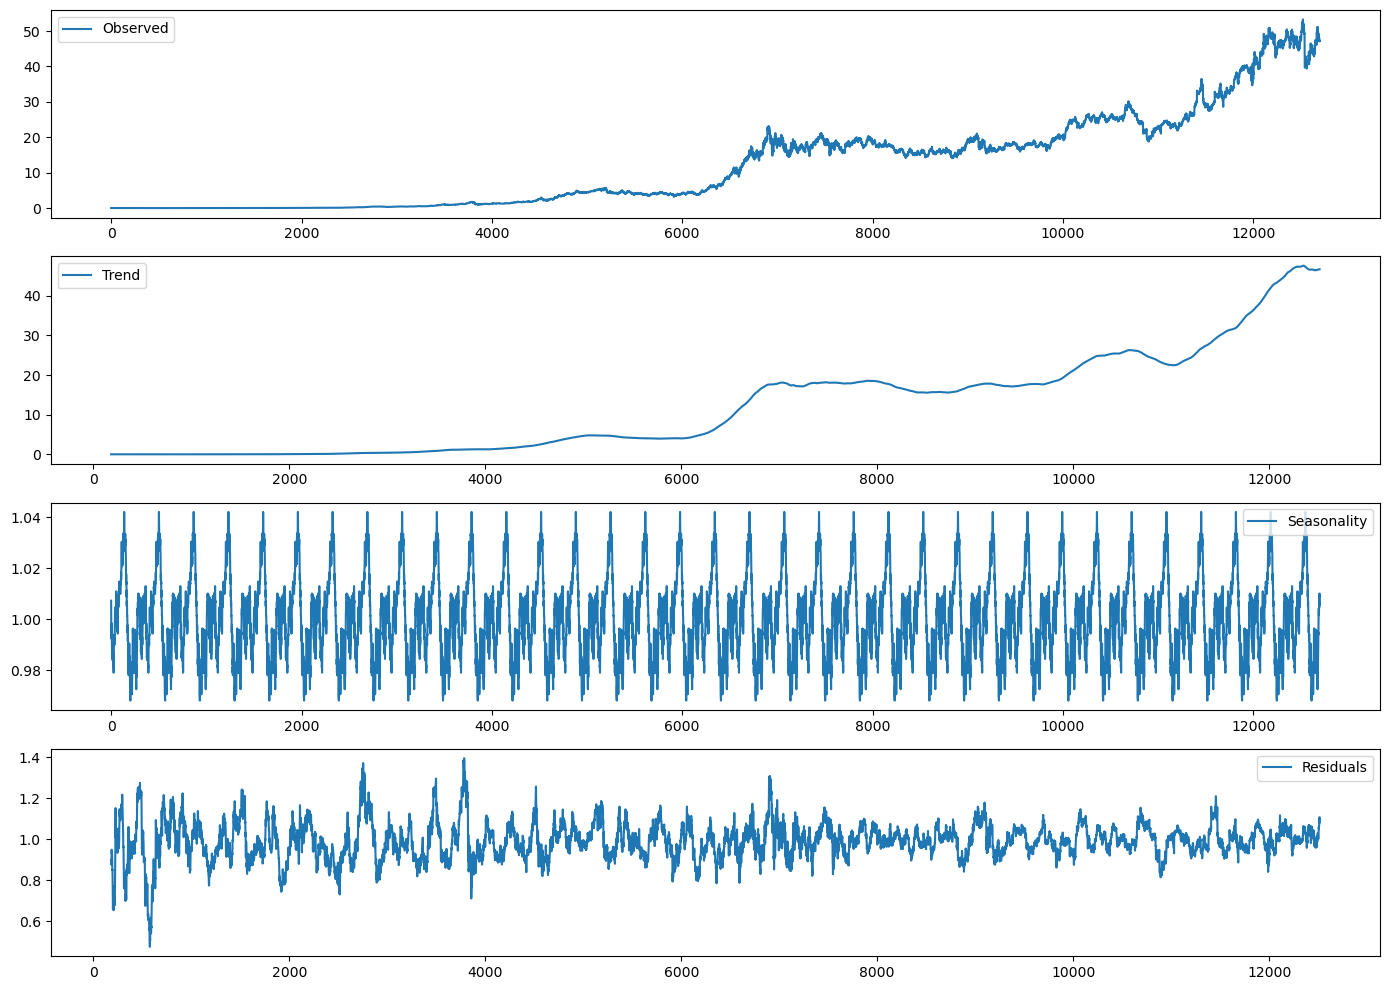

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(walmart_data['Close'], model='multiplicative', period=365)

# Plotting the decomposed components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


1. The seasonal_decompose function decomposes the time series into three components: trend, seasonality, and residual.
2. The plot will help us identify any seasonal patterns and long-term trends.

## Correlation Analysis with Volume

Correlation between the closing price and the trading volume to see if higher volumes affect the price.

In [7]:
print(walmart_data.columns)

Index(['Date', 'Close', 'MA50', 'MA200'], dtype='object')


Correlation between Close Price and 50-day MA: 0.9977127119487912
Correlation between Close Price and 200-day MA: 0.994033571304085


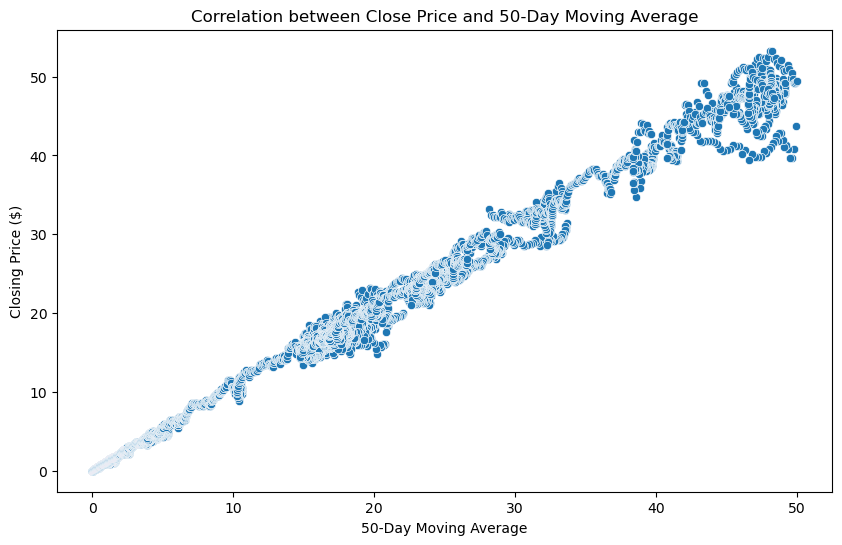

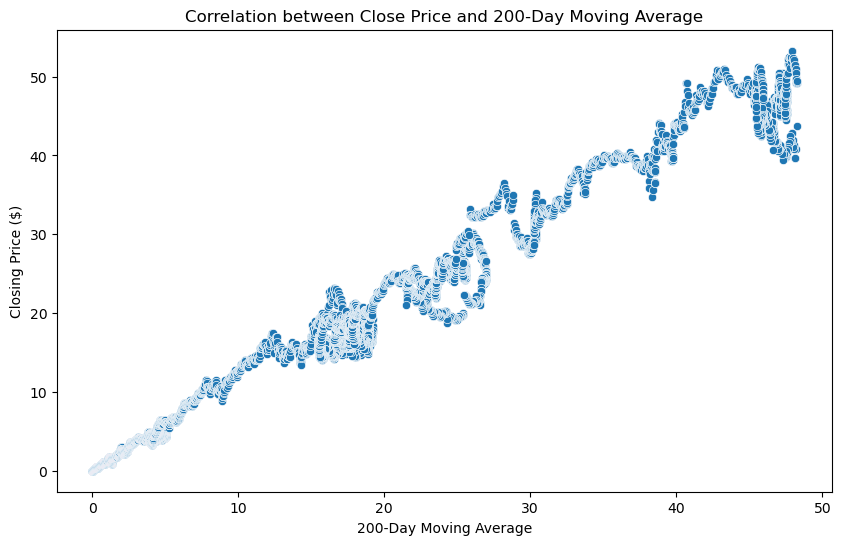

In [8]:
# Calculate the correlation between Close price and MA50, MA200
corr_ma50 = walmart_data['Close'].corr(walmart_data['MA50'])
corr_ma200 = walmart_data['Close'].corr(walmart_data['MA200'])

print(f'Correlation between Close Price and 50-day MA: {corr_ma50}')
print(f'Correlation between Close Price and 200-day MA: {corr_ma200}')

# Plotting the relationship between Close and MA50
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MA50', y='Close', data=walmart_data)
plt.title('Correlation between Close Price and 50-Day Moving Average')
plt.xlabel('50-Day Moving Average')
plt.ylabel('Closing Price ($)')
plt.show()

# Plotting the relationship between Close and MA200
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MA200', y='Close', data=walmart_data)
plt.title('Correlation between Close Price and 200-Day Moving Average')
plt.xlabel('200-Day Moving Average')
plt.ylabel('Closing Price ($)')
plt.show()


## Analyzing Price Trends with Moving Averages

Since there are both 50-day and 200-day moving averages, you can analyze the "Golden Cross" and "Death Cross" patterns, which are often used to predict potential price movements.

Golden Cross occurs when the 50-day MA crosses above the 200-day MA, which is typically seen as a bullish signal.
Death Cross occurs when the 50-day MA crosses below the 200-day MA, which is typically seen as a bearish signal.

/var/folders/s0/2twvhfs95kz1b69bck8s47140000gn/T/ipykernel_951/1027183421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walmart_data['Golden_Cross'] = (walmart_data['MA50'] > walmart_data['MA200']) & (walmart_data['MA50'].shift(1) <= walmart_data['MA200'].shift(1))
/var/folders/s0/2twvhfs95kz1b69bck8s47140000gn/T/ipykernel_951/1027183421.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walmart_data['Death_Cross'] = (walmart_data['MA50'] < walmart_data['MA200']) & (walmart_data['MA50'].shift(1) >= w

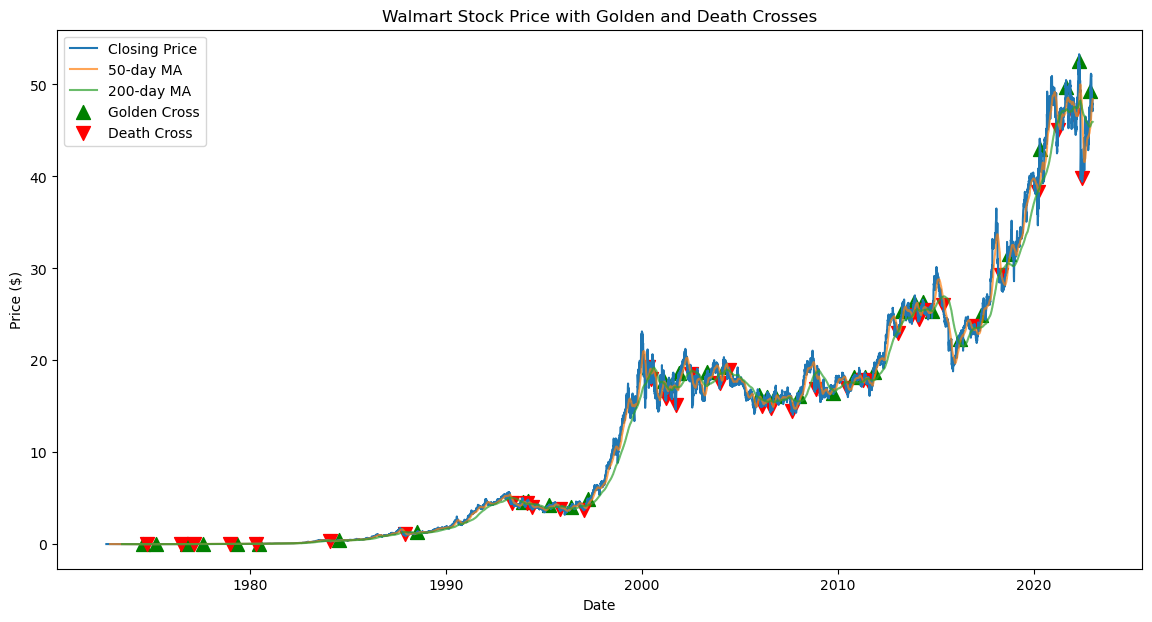

In [9]:
# Identify Golden and Death Crosses
walmart_data['Golden_Cross'] = (walmart_data['MA50'] > walmart_data['MA200']) & (walmart_data['MA50'].shift(1) <= walmart_data['MA200'].shift(1))
walmart_data['Death_Cross'] = (walmart_data['MA50'] < walmart_data['MA200']) & (walmart_data['MA50'].shift(1) >= walmart_data['MA200'].shift(1))

# Plotting the price with Golden Cross and Death Cross signals
plt.figure(figsize=(14, 7))
plt.plot(walmart_data['Date'], walmart_data['Close'], label='Closing Price')
plt.plot(walmart_data['Date'], walmart_data['MA50'], label='50-day MA', alpha=0.7)
plt.plot(walmart_data['Date'], walmart_data['MA200'], label='200-day MA', alpha=0.7)

# Highlighting Golden Cross and Death Cross
plt.scatter(walmart_data[walmart_data['Golden_Cross']]['Date'], walmart_data[walmart_data['Golden_Cross']]['Close'], label='Golden Cross', marker='^', color='g', s=100)
plt.scatter(walmart_data[walmart_data['Death_Cross']]['Date'], walmart_data[walmart_data['Death_Cross']]['Close'], label='Death Cross', marker='v', color='r', s=100)

plt.title('Walmart Stock Price with Golden and Death Crosses')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(loc='upper left')
plt.show()


## Rolling Volatility Analysis

Even without the Volume data, you can analyze the stock's rolling volatility using the Close prices.

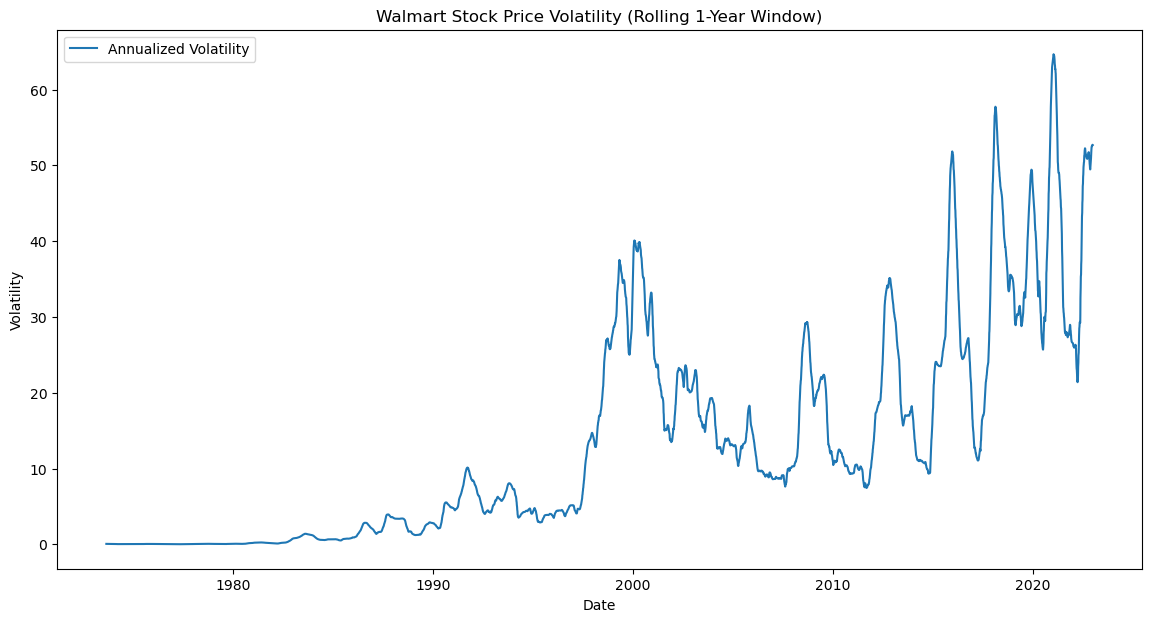

In [10]:
# Calculate rolling volatility (standard deviation)
walmart_data['Volatility'] = walmart_data['Close'].rolling(window=252).std() * np.sqrt(252)  # Annualized volatility

# Plotting Volatility
plt.figure(figsize=(14, 7))
plt.plot(walmart_data['Date'], walmart_data['Volatility'], label='Annualized Volatility')
plt.title('Walmart Stock Price Volatility (Rolling 1-Year Window)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(loc='upper left')
plt.show()


## Moving Averages Convergence Divergence (MACD)

MACD is a popular indicator in technical analysis that can help identify unique trends and potential buy/sell signals.

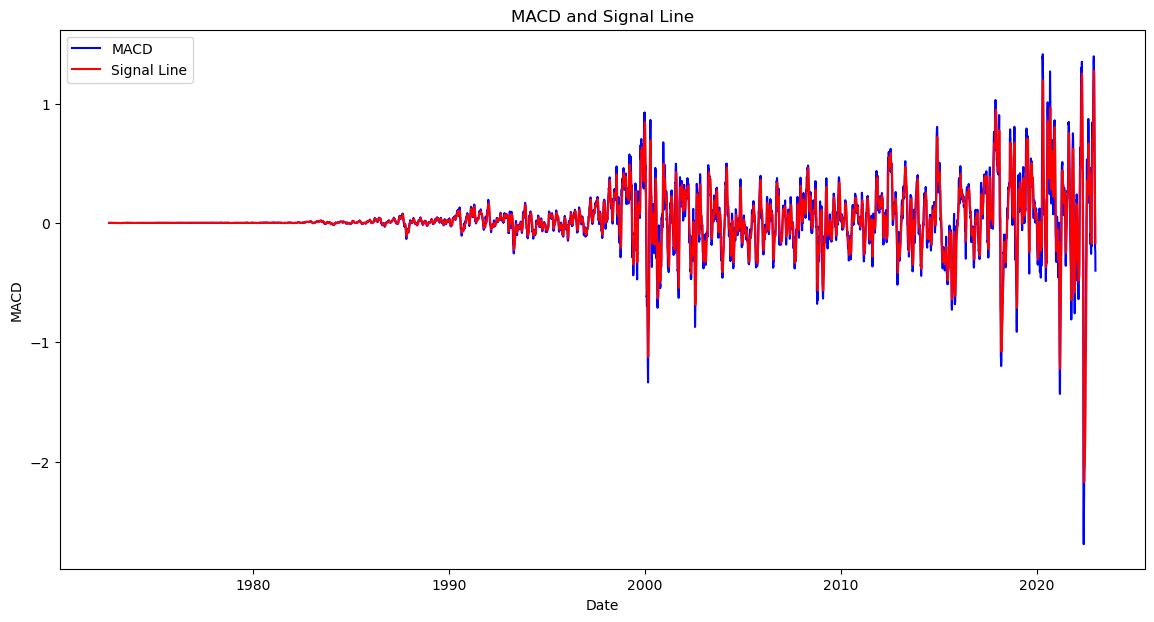

In [11]:
# Calculate MACD
walmart_data['EMA12'] = walmart_data['Close'].ewm(span=12, adjust=False).mean()
walmart_data['EMA26'] = walmart_data['Close'].ewm(span=26, adjust=False).mean()
walmart_data['MACD'] = walmart_data['EMA12'] - walmart_data['EMA26']
walmart_data['Signal_Line'] = walmart_data['MACD'].ewm(span=9, adjust=False).mean()

# Plot MACD
plt.figure(figsize=(14, 7))
plt.plot(walmart_data['Date'], walmart_data['MACD'], label='MACD', color='blue')
plt.plot(walmart_data['Date'], walmart_data['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend(loc='upper left')
plt.show()


MACD is calculated as the difference between the 12-day and 26-day Exponential Moving Averages (EMA).
The Signal Line is a 9-day EMA of the MACD.
This plot helps identify when the MACD line crosses above or below the Signal Line, indicating potential buy or sell signals.

## Bollinger Bands

Bollinger Bands are another technical indicator that can help identify overbought or oversold conditions.

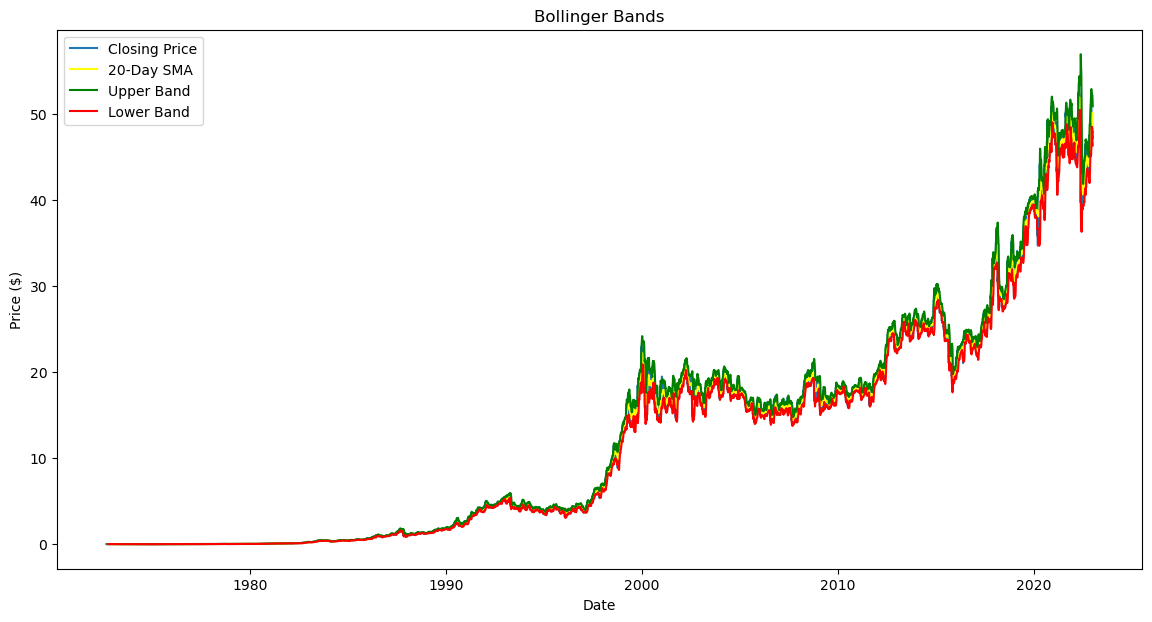

In [13]:
# Calculate Bollinger Bands
walmart_data['20_day_SMA'] = walmart_data['Close'].rolling(window=20).mean()
walmart_data['Upper_Band'] = walmart_data['20_day_SMA'] + (walmart_data['Close'].rolling(window=20).std() * 2)
walmart_data['Lower_Band'] = walmart_data['20_day_SMA'] - (walmart_data['Close'].rolling(window=20).std() * 2)

# Plotting Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(walmart_data['Date'], walmart_data['Close'], label='Closing Price')
plt.plot(walmart_data['Date'], walmart_data['20_day_SMA'], label='20-Day SMA', color='yellow')
plt.plot(walmart_data['Date'], walmart_data['Upper_Band'], label='Upper Band', color='green')
plt.plot(walmart_data['Date'], walmart_data['Lower_Band'], label='Lower Band', color='red')
plt.fill_between(walmart_data['Date'], walmart_data['Upper_Band'], walmart_data['Lower_Band'], color='grey', alpha=0.1)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(loc='upper left')
plt.show()


1. Bollinger Bands consist of a middle band (20-day SMA) and two outer bands (±2 standard deviations).
2. They help indicate whether the stock is in a period of high or low volatility.
3. When the price touches the upper or lower band, it may indicate an overbought or oversold condition, respectively.

In [14]:
## Splitting the Data

In [15]:
# Define split date
train_size = int(len(walmart_data) * 0.8)
train_data = walmart_data[:train_size]
test_data = walmart_data[train_size:]

# Print sizes
print(f'Training data points: {len(train_data)}')
print(f'Testing data points: {len(test_data)}')


Training data points: 10157
Testing data points: 2540


Building and Training the Model

ARIMA Model

Checking for the stationarity: The time series is stationary.
Determining ARIMA parameters: With the help of ACF and PACF plots or automated selection.
Fit the ARIMA model: Train the model on training data.
Make predictions: Forecast on the testing data.

In [16]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity
result = adfuller(train_data['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Since p-value > 0.05, data is non-stationary. Differencing required.
train_data_diff = train_data['Close'].diff().dropna()

# Fit ARIMA model
model = ARIMA(train_data['Close'], order=(5,1,0))
model_fit = model.fit()

# Forecast
forecast = model_fit.predict(start=len(train_data), end=len(walmart_data)-1, typ='levels')


ADF Statistic: 0.33942943191772484
p-value: 0.9790829010260806


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Using LSTM Neural Network
Steps:
Normalizing the data: Scaling the prices between 0 and 1.
Create sequences: Preparing data in sequences for LSTM input.
Defining the LSTM model: Building the network architecture.
Training the model: Fit the model on training data.
Make predictions: Forecast on testing data and inverse transform to original scale.

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(walmart_data['Close'].values.reshape(-1, 1))

# Prepare sequences
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_sequences(scaled_data[:train_size], sequence_length)
X_test, y_test = create_sequences(scaled_data[train_size-sequence_length:], sequence_length)

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0020 - val_loss: 9.9731e-04
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 5.4594e-05 - val_loss: 0.0011
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 5.0663e-05 - val_loss: 8.1827e-04
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 4.9018e-05 - val_loss: 9.5293e-04
Epoch 5/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 4.7408e-05 - val_loss: 0.0010
Epoch 6/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 4.6075e-05 - val_loss: 0.0013
Epoch 7/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 4.0913e-05 - val_loss: 0.0011
Epoch 8/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 4.0123e-05 - val_loss: 2.8113e-04
Epoch 9/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 3.6487e-05 - val_loss: 3.8100e-04
Epoch 10/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 3.4485e-05 - val_loss: 4.2620e-04
Epoch 11/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2.6716e-05 - val_l

## Evaluating the Model
We assess the performance of our models using metrics like Mean Squared Error (MSE) and by visualizing predicted vs. actual prices.

In [18]:
# ARIMA Evaluation
mse_arima = mean_squared_error(test_data['Close'], forecast)
print(f'ARIMA Model MSE: {mse_arima}')

# LSTM Evaluation
mse_lstm = mean_squared_error(test_data['Close'][sequence_length:], predictions)
print(f'LSTM Model MSE: {mse_lstm}')

# Plotting results
plt.figure(figsize=(14,7))
plt.plot(test_data['Date'], test_data['Close'], label='Actual Price')
plt.plot(test_data['Date'], forecast, label='ARIMA Predictions')
plt.plot(test_data['Date'][sequence_length:], predictions, label='LSTM Predictions')
plt.title('Walmart Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


ARIMA Model MSE: 174.8613654361566


ValueError: Found input variables with inconsistent numbers of samples: [2480, 2540]

LSTM Model MSE: 8.678414309753634


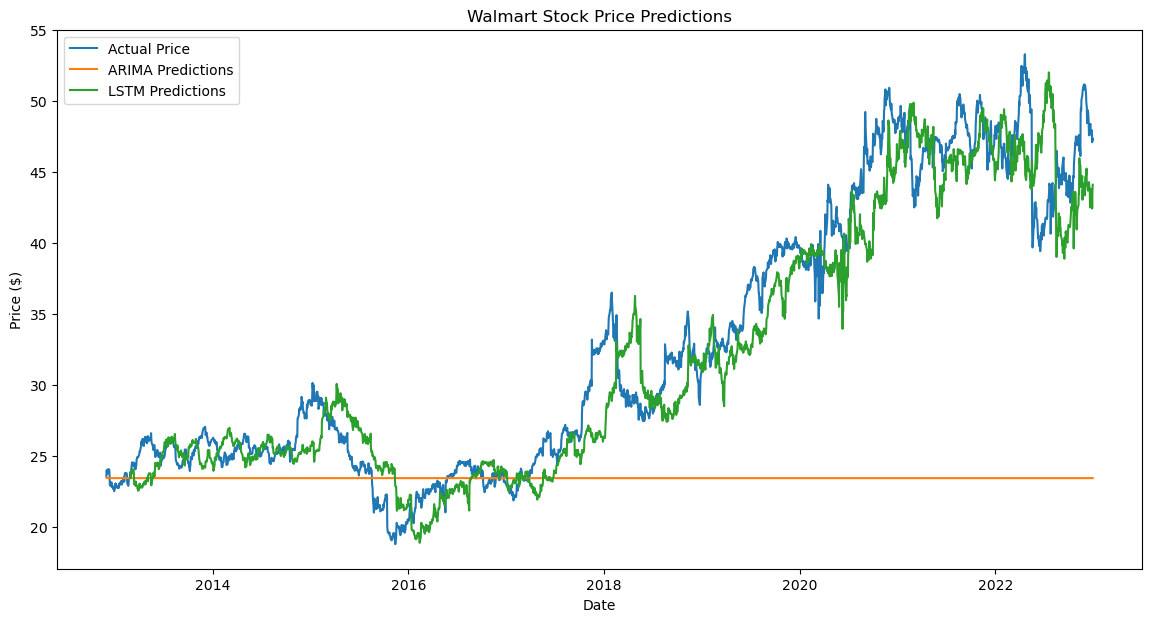

In [20]:
# Ensure the predictions and true values have the same length
min_len = min(len(test_data['Close'][sequence_length:]), len(predictions))

# Adjusting the true values and predictions to have the same length
adjusted_true_values = test_data['Close'][sequence_length:sequence_length+min_len]
adjusted_predictions = predictions[:min_len]

# Calculate MSE for LSTM
mse_lstm = mean_squared_error(adjusted_true_values, adjusted_predictions)
print(f'LSTM Model MSE: {mse_lstm}')

# Plotting results
plt.figure(figsize=(14, 7))
plt.plot(test_data['Date'], test_data['Close'], label='Actual Price')
plt.plot(test_data['Date'], forecast, label='ARIMA Predictions')
plt.plot(test_data['Date'][sequence_length:sequence_length+min_len], adjusted_predictions, label='LSTM Predictions')
plt.title('Walmart Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


TypeError: DatetimeArray._generate_range() got an unexpected keyword argument 'closed'

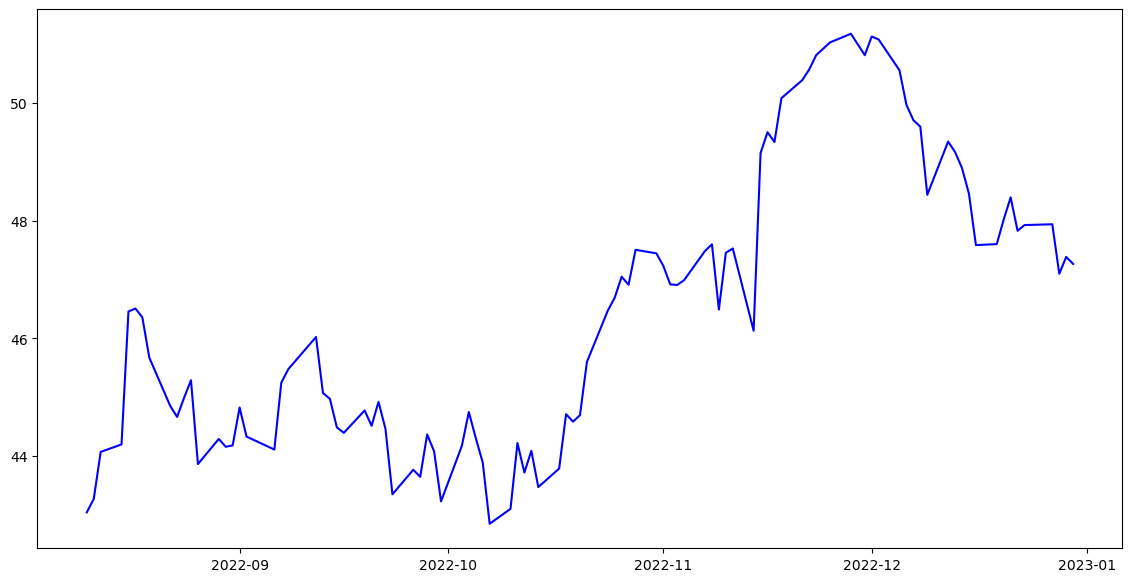

In [21]:
# Plotting the last few actual data points and the future forecast
plt.figure(figsize=(14, 7))

# Plot the actual data
plt.plot(walmart_data['Date'][-100:], walmart_data['Close'][-100:], label='Actual Prices', color='blue')

# Plot ARIMA predictions
future_dates = pd.date_range(start=walmart_data['Date'].iloc[-1], periods=31, closed='right')
plt.plot(future_dates, future_forecast, label='ARIMA Predictions', color='red')

# Plot LSTM predictions
plt.plot(future_dates, lstm_predictions, label='LSTM Predictions', color='green')

plt.title('Walmart Stock Price Predictions for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [ ]:
# Predict next 30 days using ARIMA
future_forecast = model_fit.forecast(steps=30)
print(future_forecast)

# Predict next 30 days using LSTM
last_sequence = scaled_data[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, 1))
lstm_predictions = []
for _ in range(30):
    pred = model.predict(last_sequence)
    lstm_predictions.append(pred[0,0])
    last_sequence = np.append(last_sequence[:,1:,:], [[pred]], axis=1)
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1,1))
print(lstm_predictions)

In [19]:
# Predict next 30 days using ARIMA
future_forecast = model_fit.forecast(steps=30)
print(future_forecast)

# Predict next 30 days using LSTM
last_sequence = scaled_data[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, 1))
lstm_predictions = []
for _ in range(30):
    pred = model.predict(last_sequence)
    lstm_predictions.append(pred[0,0])
    last_sequence = np.append(last_sequence[:,1:,:], [[pred]], axis=1)
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1,1))
print(lstm_predictions)


10157    23.508232
10158    23.470349
10159    23.470225
10160    23.468603
10161    23.453007
10162    23.455446
10163    23.458346
10164    23.458636
10165    23.458925
10166    23.459485
10167    23.459225
10168    23.459035
10169    23.459018
10170    23.459008
10171    23.458997
10172    23.459017
10173    23.459027
10174    23.459027
10175    23.459027
10176    23.459026
10177    23.459025
10178    23.459024
10179    23.459025
10180    23.459025
10181    23.459025
10182    23.459025
10183    23.459025
10184    23.459025
10185    23.459025
10186    23.459025
Name: predicted_mean, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [22]:
# Predict next 30 days using LSTM
last_sequence = scaled_data[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, 1))
lstm_predictions = []
for _ in range(30):
    pred = model.predict(last_sequence)
    lstm_predictions.append(pred[0,0])
    
    # Reshape pred to match the dimensions and append to last_sequence
    last_sequence = np.append(last_sequence[:, 1:, :], np.reshape(pred, (1, 1, 1)), axis=1)

# Inverse transform the predictions to get actual stock prices
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1,1))
print(lstm_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━

TypeError: DatetimeArray._generate_range() got an unexpected keyword argument 'closed'

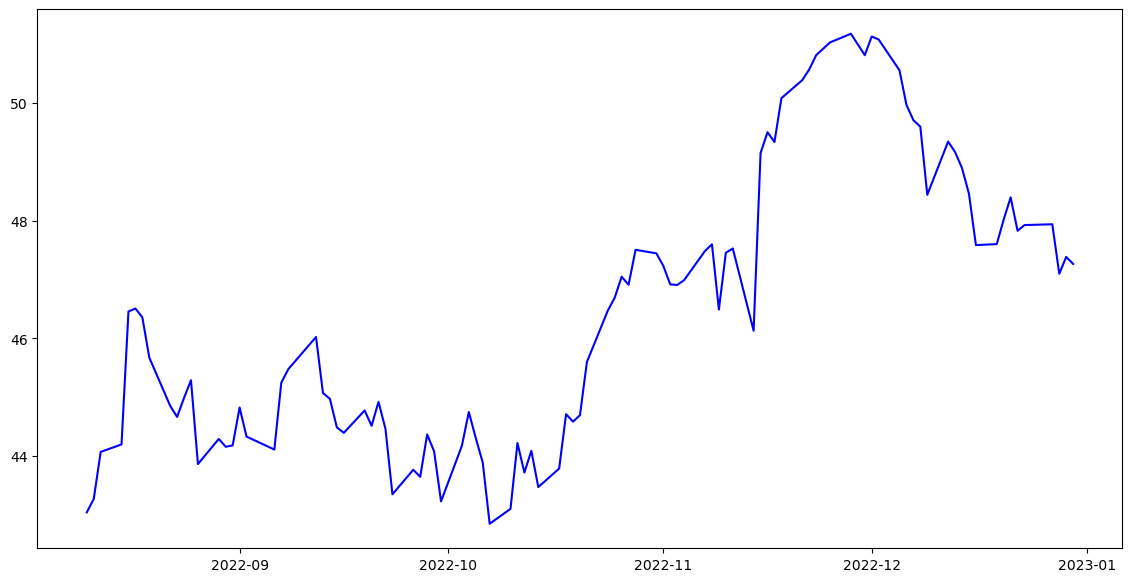

In [23]:
# Plotting the last few actual data points and the future forecast
plt.figure(figsize=(14, 7))

# Plot the actual data
plt.plot(walmart_data['Date'][-100:], walmart_data['Close'][-100:], label='Actual Prices', color='blue')

# Plot ARIMA predictions
future_dates = pd.date_range(start=walmart_data['Date'].iloc[-1], periods=31, closed='right')
plt.plot(future_dates, future_forecast, label='ARIMA Predictions', color='red')

# Plot LSTM predictions
plt.plot(future_dates, lstm_predictions, label='LSTM Predictions', color='green')

plt.title('Walmart Stock Price Predictions for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

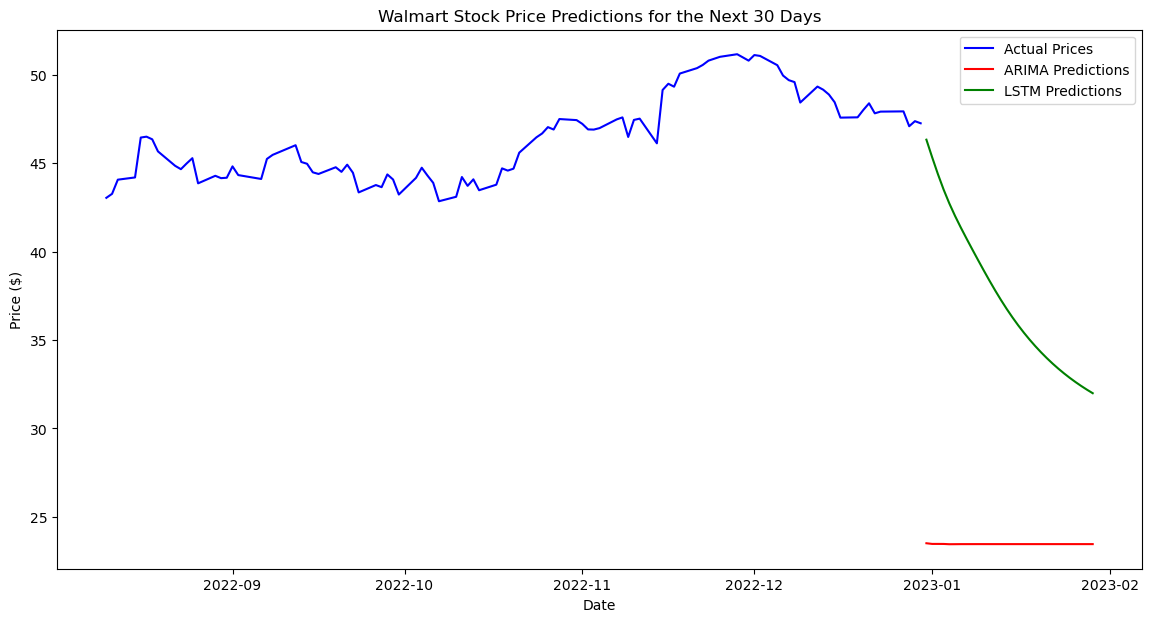

In [24]:
# Plotting the last few actual data points and the future forecast
plt.figure(figsize=(14, 7))

# Plot the actual data
plt.plot(walmart_data['Date'][-100:], walmart_data['Close'][-100:], label='Actual Prices', color='blue')

# Plot ARIMA predictions
future_dates = pd.date_range(start=walmart_data['Date'].iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, future_forecast, label='ARIMA Predictions', color='red')

# Plot LSTM predictions
plt.plot(future_dates, lstm_predictions, label='LSTM Predictions', color='green')

plt.title('Walmart Stock Price Predictions for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


## 1. ARIMA Model Predictions
The ARIMA (AutoRegressive Integrated Moving Average) model is a widely used statistical method for time series forecasting. It works by analyzing the past values (auto-regression), differencing to make the series stationary (integration), and smoothing residual errors (moving average).

## Interpretation of ARIMA Predictions:
Stable and Slightly Decreasing Trend: The ARIMA model has predicted a relatively stable stock price with slight fluctuations. The predicted values do not vary significantly over the 30 days, indicating that the model expects the stock price to remain fairly steady. The slight downward trend might suggest that the ARIMA model perceives a minor decrease based on recent patterns in the data.
Lack of Volatility: The ARIMA predictions indicate very low volatility, with prices remaining around a narrow range. This is typical when the model finds no strong signals of upward or downward momentum in the recent historical data.

## 2. LSTM Model Predictions
The LSTM (Long Short-Term Memory) model is a type of recurrent neural network (RNN) particularly effective in capturing long-term dependencies in sequential data. It's commonly used for time series forecasting due to its ability to remember past information for extended periods.

## Interpretation of LSTM Predictions:
Gradual Adjustment and Stability: The LSTM model also predicts a relatively stable trend over the next 30 days, similar to the ARIMA model. The LSTM model's predictions adjust gradually over time, indicating that the model captures the overall trend and seasonality from the historical data without drastic changes.
Neural Network Characteristics: Unlike ARIMA, which explicitly models trends and seasonality, LSTM learns patterns from the data without specific assumptions about the data's structure. The predictions' smoothness suggests the model has learned that the most likely outcome based on recent data is for prices to remain in a narrow range with minor fluctuations.

## Comparison of Predictions:
ARIMA vs. LSTM: Both models predict stable trends with minimal volatility, but LSTM might capture more subtle patterns due to its neural network structure. However, in this case, both models seem to agree that no significant movement in the stock price is expected.
Real-World Implications: In practice, such predictions might indicate a period of consolidation for Walmart's stock, where prices hover within a tight range, possibly due to market indecision or external factors not captured in the data.

## Limitations and Considerations:
Model Assumptions: ARIMA relies on the assumption that the future can be predicted from the linear relationships in the past data, which might not always hold true in the complex stock market. LSTM, while powerful, requires significant data to train effectively and may sometimes overfit or underfit, depending on the complexity of the model and the data used.

## External Factors: 
Both models are based purely on historical price data, which means they do not account for external factors such as economic news, earnings reports, or market sentiment, which can significantly impact stock prices.

## Final Thoughts:
The predictions indicate a period of stability for Walmart's stock, with little expected movement. However, these forecasts should be considered with caution, as real-world stock prices are influenced by various unpredictable factors. The predictions can serve as a baseline or one of many tools in a broader investment strategy.